In [1]:
import pandas as pd
import warnings
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML 
# display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')
train=pd.read_csv("train_data.csv")
test=pd.read_csv("test_data.csv")
import pandas_profiling as pdp
df=pd.concat([train,test],sort=False)


In [2]:
arealist=list(train.groupby("area").mean().salary.sort_values().index)
areadic={}
for i,area in enumerate(arealist):
    areadic[area]=i+1
df.area=df.area.map(areadic)
df.position=df.position+1
df.sex=df.sex-1
df.salary=np.log(df.salary)
df.education=df.education+1

# additional feature

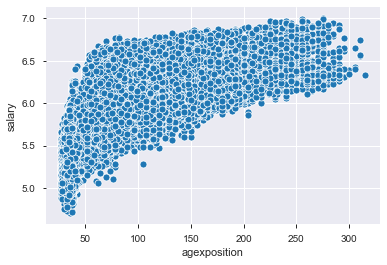

In [3]:
df["agexposition"]=df.age*df.position.map(lambda x:1.5 if x==1 else x)
sns.scatterplot(x="agexposition",y="salary",data=df)

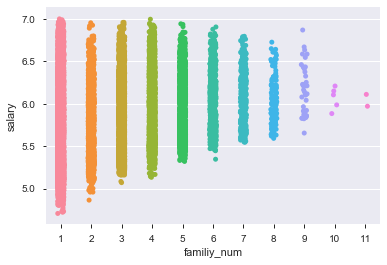

In [4]:
df["familiy_num"]=1+df.partner+df.num_child

sns.stripplot(x="familiy_num",y="salary",data=df)

In [5]:
# df["educationxage"]=df.education*df.age
# sns.scatterplot(x="educationxage",y="salary",data=df)

In [6]:
# df["overbool"]=df.overtime.map(lambda x:0 if x==0 else 1)
# df["studybool"]=df.study_time.map(lambda x:0 if x==0 else 1)


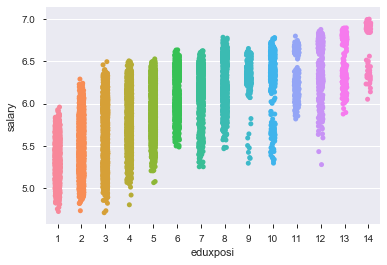

In [7]:

df["eduxposi"]=df.education*df.position
eduposilist=list(df.groupby("eduxposi").mean().salary.sort_values().index)
eduposidic={}
for i,eduposi in enumerate(eduposilist):
    eduposidic[eduposi]=i+1
df.eduxposi=df.eduxposi.map(eduposidic)
df.eduxposi
sns.stripplot(x="eduxposi",y="salary",data=df)

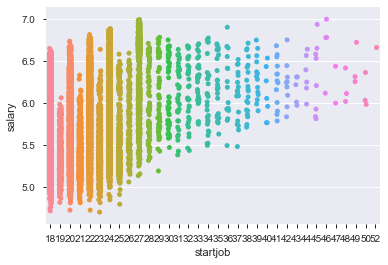

In [8]:
df["startjob"]=df.age-df.service_length
sns.stripplot(x="startjob",y="salary",data=df)

In [41]:
# fresh=((df.education==1)&(df.startjob==18))|((df.education==2)&(df.startjob==20))|((df.education==3)&(df.startjob==22))|((df.education==4)&(df.startjob==24))|((df.education==5)&(df.startjob==27))

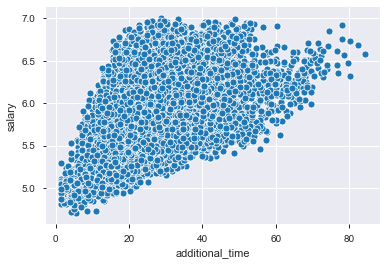

In [42]:
df["additional_time"]=df.overtime+20*df.commute*5/7
sns.scatterplot(x="additional_time",y="salary",data=df)

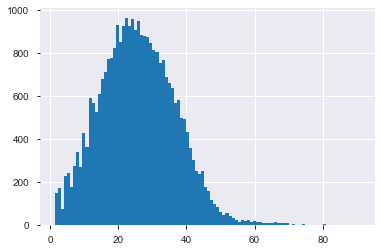

In [43]:
df.additional_time.hist(bins=100)

In [44]:
# df.loc[fresh == True, 'fresh'] = int(1 )
# df.loc[fresh == False, 'fresh'] = int(0)

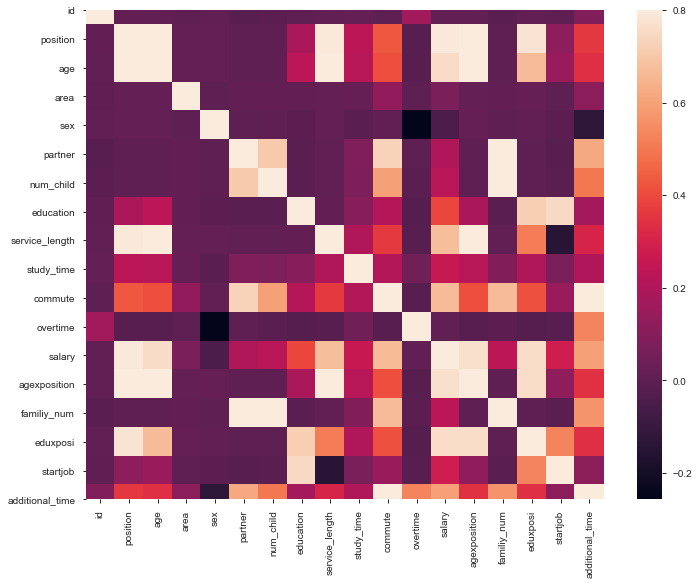

In [45]:
import seaborn as sns
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

## LeakCheck

In [46]:
# df[df.drop(["id","salary"],axis=1).duplicated(keep=False)]#リークは一つだけ

# Learning

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV

# train=df.dropna().drop(["id","sex"],axis=1)
# test=df[df.salary.isnull()].drop(["id","sex"],axis=1)
train=df.dropna().drop(["id"],axis=1)
test=df[df.salary.isnull()].drop(["id"],axis=1)
test=test.drop(["salary",],axis=1)
X = train.drop(["salary"],axis=1)

test= pd.get_dummies(test,drop_first=True, columns=['area','eduxposi'])
X = pd.get_dummies(train,drop_first=True, columns=['area','eduxposi']).drop(["salary"],axis=1)
#　目的変数に家賃単価を代入する
y = train.salary
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [48]:
pdp.ProfileReport(train)

# Liner

In [49]:
#重回帰分析
import sklearn
from sklearn.linear_model import LinearRegression as LR

model=LR()

model.fit(train_X, train_y)

linearpred=model.predict(valid_X)
model.score(valid_X,valid_y)

0.8610447235436355

# Randomforest+Feature Importances

In [50]:
from sklearn.ensemble import RandomForestRegressor as RFR
import numpy as np
from sklearn.metrics import mean_absolute_error

rg = RFR(n_jobs=-1, random_state=2525)
 
rg.fit(train_X,train_y)
print(rg.score(valid_X,valid_y))
from sklearn.metrics import mean_squared_error
score=mean_absolute_error(np.exp(valid_y),np.exp(rg.predict(valid_X)))
print(f'MAE:{score:4f}')
fti = rg.feature_importances_

print('Feature Importances:')
for i,feat in enumerate(valid_X.columns):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))
col_names = test.columns.values
col_names_ = col_names[np.argsort(rg.feature_importances_)[::-1]]
col_names_

0.9502386325974229
MAE:24.729274
Feature Importances:
	position   : 0.009937
	age        : 0.003042
	sex        : 0.000806
	partner    : 0.008722
	num_child  : 0.009397
	education  : 0.043416
	service_length : 0.003066
	study_time : 0.003631
	commute    : 0.203980
	overtime   : 0.007404
	agexposition : 0.628725
	familiy_num : 0.029688
	startjob   : 0.002322
	additional_time : 0.024782
	area_2     : 0.000196
	area_3     : 0.000207
	area_4     : 0.000185
	area_5     : 0.000228
	area_6     : 0.000234
	area_7     : 0.000165
	area_8     : 0.000333
	area_9     : 0.000262
	area_10    : 0.000285
	area_11    : 0.000270
	area_12    : 0.000265
	area_13    : 0.000219
	area_14    : 0.000323
	area_15    : 0.000278
	area_16    : 0.000334
	area_17    : 0.000272
	area_18    : 0.000266
	area_19    : 0.000271
	area_20    : 0.000291
	area_21    : 0.000257
	area_22    : 0.000324
	area_23    : 0.000336
	area_24    : 0.000542
	area_25    : 0.000233
	area_26    : 0.000205
	area_27    : 0.000286
	area_28    : 

array(['agexposition', 'commute', 'education', 'familiy_num',
       'additional_time', 'position', 'num_child', 'partner', 'overtime',
       'study_time', 'area_47', 'service_length', 'age', 'startjob',
       'area_46', 'sex', 'area_37', 'area_24', 'eduxposi_3', 'eduxposi_2',
       'eduxposi_4', 'eduxposi_8', 'area_45', 'eduxposi_6', 'area_23',
       'area_16', 'area_8', 'eduxposi_7', 'area_22', 'area_14', 'area_30',
       'area_34', 'eduxposi_12', 'eduxposi_5', 'area_20', 'area_27',
       'area_10', 'area_38', 'area_15', 'area_17', 'area_19', 'area_11',
       'area_29', 'area_18', 'area_12', 'area_9', 'area_42', 'area_28',
       'area_21', 'area_36', 'area_39', 'area_32', 'area_44', 'area_35',
       'area_6', 'area_25', 'area_5', 'area_13', 'area_40', 'area_3',
       'area_26', 'area_43', 'area_2', 'area_31', 'area_41', 'area_4',
       'eduxposi_14', 'area_33', 'area_7', 'eduxposi_11', 'eduxposi_13',
       'eduxposi_10', 'eduxposi_9'], dtype=object)

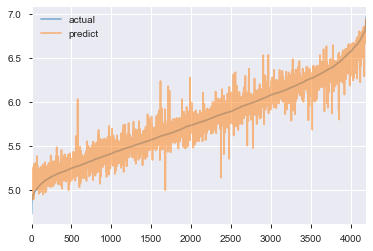

In [51]:
checktesty=valid_y.sort_values()
checktestX=valid_X.ix[list(checktesty.index)]
checktesty=checktesty.reset_index(drop=True)#これと

checkpred=pd.DataFrame(rg.predict(checktestX))#これ
check=pd.concat([checktesty,checkpred], axis=1)
check.columns=["actual","predict"]
check.plot(alpha=0.5)

# ModelSelection


 80%|████████  | 8/10 [04:07<00:38, 19.40s/it]

[11:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:55:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:55:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:55:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n


100%|██████████| 10/10 [05:08<00:00, 30.89s/it]


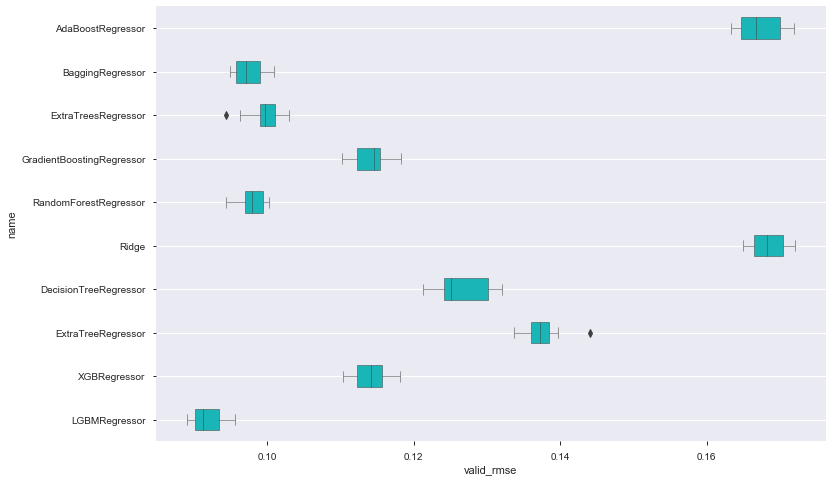

In [253]:
# 特徴量を選択して、複数のモデルで精度を調査する
from scipy.stats import mstats
from tqdm import tqdm
import matplotlib
from sklearn import metrics,  feature_selection, ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis, model_selection
# from imblearn import under_sampling, over_sampling
from sklearn.metrics import make_scorer
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
base_color = 'darkturquoise'
base_color2 = 'gray'

def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
    return matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', color_list)
cm = generate_cmap([base_color2, 'white', base_color])

def rmse_score(y_true, y_pred):
    """RMSE (Root Mean Square Error: 平均二乗誤差平方根) を計算する関数"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

params={'booster': 'dart', 
        'alpha': 0.009385870161072372, 
        'max_depth': 9, 'eta': 2.3698818355249718e-07,
        'gamma': 3.167530221746867e-05, 
        'grow_policy': 'lossguide',
        'sample_type': 'weighted',
        'normalize_type': 'forest',
        'rate_drop': 3.1207262366715483e-08,
        'skip_drop': 1.2650261386504368e-05}


models = [
 
    #Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
 
    #Gaussian Processes
#     gaussian_process.GaussianProcessRegressor(),
    
    #GLM
    linear_model.Ridge(),

    
    #Trees    
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
 
    #xgboost
    xgb. XGBRegressor(),
    lgb.LGBMRegressor(),
#     cat.CatBoostRegressor(),
    
]
 
df_compare = pd.DataFrame(columns=['name', 'train_rmse', 'valid_rmse', 'time'])
score_funcs = {
    'rmse': make_scorer(rmse_score),
}

for model in tqdm(models):
    
    name = model.__class__.__name__
    
    cv_rlts = model_selection.cross_validate(model,X,y, scoring=score_funcs, cv=10, return_train_score=True)
 
    for i in range(10):
        s = pd.Series([name, cv_rlts['train_rmse'][i], cv_rlts['test_rmse'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name=name+str(i))
        df_compare = df_compare.append(s)
        
plt.figure(figsize=(12,8))
sns.boxplot(data=df_compare, y='name', x='valid_rmse', orient='h', color=base_color, linewidth=0.5, width=0.5)
plt.grid()
plt.show()

In [52]:
cols = X.columns.tolist()
 
# positive_cnt = int(df['salary'].sum())

feature_importance_models = [
    ensemble.AdaBoostRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    tree.DecisionTreeRegressor(),
    xgb.XGBRegressor(),
    lgb.LGBMRegressor()
]
 
scoring = ['rsme']
df_rfe_cols_cnt = pd.DataFrame(columns=['cnt'], index=cols)
df_rfe_cols_cnt['cnt'] = 0
 
for i, model in tqdm(enumerate(feature_importance_models), total=len(feature_importance_models)):
    
    rfe = feature_selection.RFECV(model, step=3)
    rfe.fit(X, y)
#     print(rfe.get_support())
    rfe_cols = X[cols].columns.values[rfe.get_support()]
    df_rfe_cols_cnt.loc[rfe_cols, 'cnt'] += 1
    
df_rfe_cols_cnt.plot(kind='bar', color=base_color, figsize=(15, 5))
plt.show()

NameError: name 'ensemble' is not defined

In [386]:
x_cols = df_rfe_cols_cnt[df_rfe_cols_cnt['cnt'] < 4].index
X=X.drop(x_cols,axis=1)
test=test.drop(x_cols,axis=1)
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [62]:
# cat_list = ['area', 'sex', 'partner','education']

## XGBoost+optuna

In [55]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import optuna
from sklearn.metrics import r2_score

class RidgeCV():
    model_cls = Ridge

    def __init__(self, n_trials=100):
        self.n_trials = n_trials

    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
        elif isinstance(X, pd.DataFrame):
            X = X.reset_index(drop=True)
            y = y.reset_index(drop=True)

        self.X = X
        self.y = y

        study = optuna.create_study(direction='maximize')
        study.optimize(self, n_trials=self.n_trials)
        self.best_trial = study.best_trial

        print()
        print("Best score:", round(self.best_trial.value, 2))
        print("Best params:", self.best_trial.params)
        print()

        self.best_model = self.model_cls(**self.best_trial.params)
        self.best_model.fit(self.X, self.y)

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X.values.reshape(1, -1))
        elif isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        return self.best_model.predict(X)

    def score(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)

        return self.best_model.score(X, y)

    def kfold_cv(self, model, splits=5):
        scores = []

        kf = KFold(n_splits=splits, shuffle=True)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            model.fit(X_train, y_train)
            scores.append(r2_score(model.predict(X_test), y_test))

        score = np.array(scores).mean()
        return score

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

class XGBRegressorCV(RidgeCV):
    model_cls = xgb.XGBRegressor

    def __call__(self, trial):
        booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
        alpha = trial.suggest_loguniform('alpha', 1e-8, 1.0)

        max_depth = trial.suggest_int('max_depth', 1, 20)
        eta = trial.suggest_loguniform('eta', 1e-8, 1.0)
        gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        grow_policy = trial.suggest_categorical(
            'grow_policy', ['depthwise', 'lossguide'])

        if booster == 'gbtree':
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy)
        elif booster == 'dart':
            sample_type = trial.suggest_categorical('sample_type',
                                                    ['uniform', 'weighted'])
            normalize_type = trial.suggest_categorical('normalize_type',
                                                       ['tree', 'forest'])
            rate_drop = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
            skip_drop = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy,
                                   sample_type=sample_type,
                                   normalize_type=normalize_type,
                                   rate_drop=rate_drop, skip_drop=skip_drop)

        score = self.kfold_cv(model)
        return score

xgbr = XGBRegressorCV(n_trials=20)
xgbr.fit(train_X, train_y)

pred_y=xgbr.predict(valid_X)
score=mean_absolute_error(np.exp(valid_y),np.exp(xgbr.predict(valid_X)))
print(f'MAE:{score:4f}')
#MAE:22.821581(drop)dummy
#MAE:22.753628(nodrop)dummy

[I 2019-11-18 23:40:42,327] Finished trial#0 resulted in value: 0.9551699770912034. Current best value is 0.9551699770912034 with parameters: {'booster': 'dart', 'alpha': 0.3085115174101181, 'max_depth': 9, 'eta': 1.0732568515145836e-06, 'gamma': 2.182939359055782e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.061792612896835e-05, 'skip_drop': 0.3430440791917346}.
[I 2019-11-18 23:41:42,017] Finished trial#1 resulted in value: 0.9526495318971703. Current best value is 0.9551699770912034 with parameters: {'booster': 'dart', 'alpha': 0.3085115174101181, 'max_depth': 9, 'eta': 1.0732568515145836e-06, 'gamma': 2.182939359055782e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.061792612896835e-05, 'skip_drop': 0.3430440791917346}.
[I 2019-11-18 23:41:53,507] Finished trial#2 resulted in value: 0.8174511403420268. Current best value is 0.9551699770912034 with parameters: {'booster': 


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 9.279257368332313e-07, 'max_depth': 14, 'eta': 0.0014466374754946892, 'gamma': 0.008724424777063254, 'grow_policy': 'depthwise'}

[00:10:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE:22.886663


position  age  sex  partner  num_child  education  service_length  \
0             2   44    1        1          2          2              24   
1             3   31    0        0          0          1              13   
2             3   36    0        0          0          3              14   
3             1   22    1        0          0          1               4   
4             1   25    1        0          0          2               5   
...         ...  ...  ...      ...        ...        ...             ...   
20995         1   27    1        0          0          2               7   
20996         1   22    1        0          0          1               4   
20997         4   36    1        0          0          3              14   
20998         1   21    1        1          2          2               0   
20999         2   30    0        0          0          4               6   

       study_time  commute  overtime  ...  area_37  area_44  area_45  area_46  \
0             2.0      1.6       9.2  ...        0        0        1        0   
1             9.0      0.7      12.4  ...        0        0        0        0   
2             4.0      0.4      16.9  ...        0        0        0        0   
3             3.0      0.4       6.1  ...        0        0        0        0   
4             3.0      0.2       4.9  ...        0        0        0        0   
...           ...      ...       ...  ...      ...      ...      ...      ...   
20995         2.0      0.2      15.5  ...        0        0        0        0   
20996         3.0      0.2      13.4  ...        0        1        0        0   
20997         4.0      0.8      12.7  ...        0        0        0        0   
20998         1.0      1.0      10.9  ...        0        0        0        0   
20999         0.0      0.5      19.8  ...        0        0        0        0   

       area_47  eduxposi_2  eduxposi_3  eduxposi_4  eduxposi_5  eduxposi_13  
0            0           0           0           1           0            0  
1            0           0           1           0           0            0  
2            0           0           0           0           0            0  
3            1           0           0           0           0            0  
4            0           1           0           0           0            0  
...        ...         ...         ...         ...         ...          ...  
20995        0           1           0           0           0            0  
20996        0           0           0           0           0            0  
20997        0           0           0           0           0            0  
20998        0           1           0           0           0            0  
20999        0           0           0           0           0            0  

[21000 rows x 26 columns]

# LightGBM+optuna

[I 2019-11-18 23:35:06,096] Finished trial#0 resulted in value: 0.9454941817825983. Current best value is 0.9454941817825983 with parameters: {'booster': 'gbtree', 'iterations': 309, 'depth': 23, 'learning_rate': 0.09654858601305907, 'random_strength': 1, 'bagging_temperature': 0.11878187801208552, 'od_type': 'IncToDec', 'od_wait': 33, 'lambda_l1': 8.124626268579605e-07, 'lambda_l2': 3.1899395778800063e-06, 'num_leaves': 13, 'feature_fraction': 0.7208478857954597, 'bagging_fraction': 0.76616863139859, 'bagging_freq': 4, 'min_child_samples': 40}.
[I 2019-11-18 23:35:09,094] Finished trial#1 resulted in value: 0.9535583232443428. Current best value is 0.9535583232443428 with parameters: {'booster': 'gbtree', 'iterations': 133, 'depth': 14, 'learning_rate': 0.16798433101610669, 'random_strength': 63, 'bagging_temperature': 0.5193644076485131, 'od_type': 'Iter', 'od_wait': 38, 'lambda_l1': 1.1162704753712194e-08, 'lambda_l2': 2.7116885698319827e-05, 'num_leaves': 40, 'feature_fraction': 0.


Best score: 0.96
Best params: {'booster': 'gbtree', 'iterations': 252, 'depth': 20, 'learning_rate': 0.0783530701074473, 'random_strength': 87, 'bagging_temperature': 0.05361131776651505, 'od_type': 'Iter', 'od_wait': 39, 'lambda_l1': 2.8244707888732837e-05, 'lambda_l2': 2.3186341622370716e-07, 'num_leaves': 132, 'feature_fraction': 0.7780029243858917, 'bagging_fraction': 0.8727412749378808, 'bagging_freq': 6, 'min_child_samples': 40}

MAE:22.978763


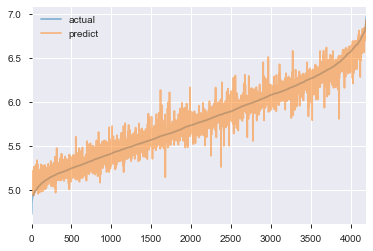

In [54]:
# coding:utf-8
import lightgbm as lgb
# from sklearn.metrics import log_loss
def min_max_normalization(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / ( x_max - x_min)
    return x_norm
def min_max_renormalization(x1,x2):
    x_min = x2.min()
    x_max = x2.max()
#     x_norm = (x2 - x_min) / ( x_max - x_min)
    x=x1*  ( x_max - x_min)+x_min
    return x

import lightgbm as lgb
# from sklearn.metrics import log_loss
cat_list = ['area', 'sex', 'partner','education']
class LGBRegressorCV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            'eval_metric':'mae',
            'booster':trial.suggest_categorical('booster',['gbtree','gblinear']),
            'loss_function': 'fair',
            'iterations' : trial.suggest_int('iterations', 50, 400),                      
            'depth' : trial.suggest_int('depth', 4, 25),                                      
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50),
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressorCV(n_trials=20)
model.fit(train_X,train_y)

pred_y=model.predict(valid_X)
score=mean_absolute_error(np.exp(valid_y),np.exp(pred_y))
print(f'MAE:{score:4f}')
# pred=model.predict(test)
    
checktesty=valid_y.sort_values()
checktestX=valid_X.ix[list(checktesty.index)]
checktesty=checktesty.reset_index(drop=True)#これと

checkpred=pd.DataFrame(model.predict(checktestX))#これ
check=pd.concat([checktesty,checkpred], axis=1)
check.columns=["actual","predict"]
check.plot(alpha=0.5)
#MAE:23.144563 (nodrop)dummy
#MAE:23.742147(drop)dummy
#MAE:23.902507nodummy

In [373]:
    
class LGBRegressor1CV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            'loss_function': 'xentropy loss',
            'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 8, 20),                                      
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressor1CV(n_trials=40)
train_ylgm=min_max_normalization(train_y)
model.fit(train_X,train_ylgm)

pred_y=min_max_renormalization(model.predict(valid_X),train_y)
score=mean_absolute_error(np.exp(valid_y),np.exp(pred_y))
print(f'MAE:{score:4f}')
pred=model.predict(test)


[I 2019-11-18 18:55:39,033] Finished trial#0 resulted in value: 0.9281146151684363. Current best value is 0.9281146151684363 with parameters: {'iterations': 299, 'depth': 13, 'learning_rate': 0.9735584437355863, 'random_strength': 68, 'bagging_temperature': 0.038503718269643196, 'od_type': 'IncToDec', 'od_wait': 33}.
[I 2019-11-18 18:56:01,971] Finished trial#1 resulted in value: 0.9549552122101819. Current best value is 0.9549552122101819 with parameters: {'iterations': 160, 'depth': 10, 'learning_rate': 0.08505698872657419, 'random_strength': 46, 'bagging_temperature': 0.6124333150722396, 'od_type': 'Iter', 'od_wait': 46}.
[I 2019-11-18 18:56:18,910] Finished trial#2 resulted in value: 0.9281375487037756. Current best value is 0.9549552122101819 with parameters: {'iterations': 160, 'depth': 10, 'learning_rate': 0.08505698872657419, 'random_strength': 46, 'bagging_temperature': 0.6124333150722396, 'od_type': 'Iter', 'od_wait': 46}.
[I 2019-11-18 18:56:31,906] Finished trial#3 resulted

KeyboardInterrupt: 

In [144]:
class LGBRegressor2CV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            
            'loss_function': 'regression_l1',
            'iterations' : trial.suggest_int('iterations', 50, 400),                      
            'depth' : trial.suggest_int('depth', 4, 25),                                      
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressor2CV(n_trials=40)
model.fit(train_X,train_y)

pred_y=model.predict(valid_X)
score=mean_absolute_error(np.exp(valid_y),np.exp(pred_y))
print(f'MAE:{score:4f}')

[I 2019-11-18 00:02:34,239] Finished trial#0 resulted in value: 0.9569148322685755. Current best value is 0.9569148322685755 with parameters: {'iterations': 399, 'depth': 21, 'learning_rate': 0.13750394274194355, 'random_strength': 87, 'bagging_temperature': 23.688301507521178, 'od_type': 'Iter', 'od_wait': 32}.
[I 2019-11-18 00:02:38,582] Finished trial#1 resulted in value: 0.4902221876787675. Current best value is 0.9569148322685755 with parameters: {'iterations': 399, 'depth': 21, 'learning_rate': 0.13750394274194355, 'random_strength': 87, 'bagging_temperature': 23.688301507521178, 'od_type': 'Iter', 'od_wait': 32}.
[I 2019-11-18 00:02:42,366] Finished trial#2 resulted in value: 0.9331576859174158. Current best value is 0.9569148322685755 with parameters: {'iterations': 399, 'depth': 21, 'learning_rate': 0.13750394274194355, 'random_strength': 87, 'bagging_temperature': 23.688301507521178, 'od_type': 'Iter', 'od_wait': 32}.
[I 2019-11-18 00:02:44,900] Finished trial#3 resulted in v


Best score: 0.96
Best params: {'iterations': 55, 'depth': 22, 'learning_rate': 0.15022735769525583, 'random_strength': 40, 'bagging_temperature': 0.03207087240546606, 'od_type': 'Iter', 'od_wait': 41}

MAE:23.414411


## CatBoost+optuna(non recomended)

In [52]:
from catboost import CatBoost
# from sklearn.metrics import log_loss

class CatRegressorCV(RidgeCV):
    model_cls = CatBoost
    def __call__(self, trial):
        params = {
            'loss_function': 'RMSE',
#             'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 4, 16),                                      
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(params)
        score = self.kfold_cv(model)
        return score
model=CatRegressorCV()
model.fit(train_X,train_y)

pred_y=model.predict(valid_X)
score=mean_absolute_error(np.exp(valid_y),np.exp(model.predict(valid_X)))
print(f'MAE:{score:4f}')
pred=model.predict(test)

0:	learn: 0.4384277	total: 5.61ms	remaining: 5.61s
1:	learn: 0.4285259	total: 11.8ms	remaining: 5.89s
2:	learn: 0.4189667	total: 19.2ms	remaining: 6.37s
3:	learn: 0.4126162	total: 24.6ms	remaining: 6.13s
4:	learn: 0.4062148	total: 32.5ms	remaining: 6.47s
5:	learn: 0.3972057	total: 38.4ms	remaining: 6.37s
6:	learn: 0.3892128	total: 44.2ms	remaining: 6.27s
7:	learn: 0.3809407	total: 49.9ms	remaining: 6.19s
8:	learn: 0.3728918	total: 60.9ms	remaining: 6.7s
9:	learn: 0.3655981	total: 70.1ms	remaining: 6.94s
10:	learn: 0.3599157	total: 76.7ms	remaining: 6.89s
11:	learn: 0.3535651	total: 83.5ms	remaining: 6.88s
12:	learn: 0.3493127	total: 89.2ms	remaining: 6.78s
13:	learn: 0.3434051	total: 96.8ms	remaining: 6.82s
14:	learn: 0.3384453	total: 105ms	remaining: 6.93s
15:	learn: 0.3328524	total: 112ms	remaining: 6.89s
16:	learn: 0.3269959	total: 118ms	remaining: 6.8s
17:	learn: 0.3207634	total: 127ms	remaining: 6.91s
18:	learn: 0.3146285	total: 139ms	remaining: 7.16s
19:	learn: 0.3100011	total: 1

160:	learn: 0.1658935	total: 1.55s	remaining: 8.1s
161:	learn: 0.1656159	total: 1.56s	remaining: 8.07s
162:	learn: 0.1655277	total: 1.57s	remaining: 8.07s
163:	learn: 0.1654941	total: 1.58s	remaining: 8.08s
164:	learn: 0.1654018	total: 1.6s	remaining: 8.12s
165:	learn: 0.1653622	total: 1.62s	remaining: 8.12s
166:	learn: 0.1652721	total: 1.62s	remaining: 8.1s
167:	learn: 0.1652336	total: 1.64s	remaining: 8.11s
168:	learn: 0.1651917	total: 1.65s	remaining: 8.09s
169:	learn: 0.1649932	total: 1.66s	remaining: 8.09s
170:	learn: 0.1649496	total: 1.66s	remaining: 8.07s
171:	learn: 0.1648867	total: 1.67s	remaining: 8.05s
172:	learn: 0.1647676	total: 1.68s	remaining: 8.03s
173:	learn: 0.1643800	total: 1.69s	remaining: 8.01s
174:	learn: 0.1643661	total: 1.7s	remaining: 8s
175:	learn: 0.1643300	total: 1.71s	remaining: 7.98s
176:	learn: 0.1638879	total: 1.72s	remaining: 7.98s
177:	learn: 0.1636551	total: 1.72s	remaining: 7.95s
178:	learn: 0.1636145	total: 1.73s	remaining: 7.95s
179:	learn: 0.16354

KeyboardInterrupt: 

## Data engeneering for NN

In [53]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
categorical_variable_names = ["position","sex","education"]
# カテゴリ変数に一括変換
# x_dummy = pd.get_dummies(df[categorical_variable_names], drop_first=True,columns=categorical_variable_names)
X_nn=df.drop(categorical_variable_names, axis=1)
X_nn=df
sscaler =StandardScaler()
sscaler.fit(X_nn)  

x_datas_std =sscaler.transform(X_nn)
x_datas_std = pd.DataFrame(x_datas_std, columns=X_nn.columns)
X_nn= pd.concat([x_datas_std,], axis=1)

train_X_nn=X_nn.dropna().drop("id",axis=1)
test_nn=X_nn[X_nn.salary.isnull()].drop("id",axis=1)
test_nn= test_nn.drop(["salary",],axis=1)
X_nn= train_X_nn.drop(["salary"],axis=1)

In [54]:
#ニューラルネットワークモデルの生成
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(800, activation = 'relu'))
model.add(Dense(100, activation =  'relu'))
model.add(Dense(1))
# モデルをコンパイル 
from keras.optimizers import Adam

train_X_nn, valid_X_nn,train_y_nn, valid_y_nn = train_test_split(X_nn,y,test_size=0.2,random_state=43)

model.compile(Adam(lr=1e-3), loss="mean_squared_error")
#トレーニングデータで学習し，テストデータで評価（平均2乗誤差を用いる）
history = model.fit(np.array(train_X_nn), np.array(train_y_nn), batch_size=128, epochs=500, verbose=1, 
          validation_data=(np.array(valid_X_nn), np.array(valid_y_nn)))

Using TensorFlow backend.


Train on 16800 samples, validate on 4200 samples
Epoch 1/500
16800/16800 [==============================] - ETA: 40s - loss: 32.513 - ETA: 11s - loss: 17.096 - ETA: 6s - loss: 11.948 - ETA: 5s - loss: 9.1769 - ETA: 4s - loss: 7.915 - ETA: 4s - loss: 7.049 - ETA: 3s - loss: 6.172 - ETA: 3s - loss: 5.553 - ETA: 3s - loss: 5.084 - ETA: 3s - loss: 4.643 - ETA: 2s - loss: 4.300 - ETA: 2s - loss: 4.005 - ETA: 2s - loss: 3.747 - ETA: 2s - loss: 3.524 - ETA: 2s - loss: 3.324 - ETA: 2s - loss: 3.145 - ETA: 2s - loss: 3.039 - ETA: 2s - loss: 2.892 - ETA: 2s - loss: 2.805 - ETA: 2s - loss: 2.721 - ETA: 1s - loss: 2.606 - ETA: 1s - loss: 2.505 - ETA: 1s - loss: 2.408 - ETA: 1s - loss: 2.349 - ETA: 1s - loss: 2.264 - ETA: 1s - loss: 2.210 - ETA: 1s - loss: 2.160 - ETA: 1s - loss: 2.111 - ETA: 1s - loss: 2.066 - ETA: 1s - loss: 2.024 - ETA: 1s - loss: 1.963 - ETA: 1s - loss: 1.904 - ETA: 1s - loss: 1.848 - ETA: 1s - loss: 1.796 - ETA: 0s - loss: 1.746 - ETA: 0s - loss: 1.700 - ETA: 0s - loss: 1.655 

16800/16800 [==============================] - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 5s - loss: 0.015 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 4s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.010 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.014 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.010 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.010 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.009 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.006 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.004 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 5s - loss: 0.005 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0

Epoch 286/500
16800/16800 [==============================] - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA

16800/16800 [==============================] - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 8s - loss: 0.005 - ETA: 5s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 5s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0

16800/16800 [==============================] - ETA: 5s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0

16800/16800 [==============================] - ETA: 8s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.005 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.006 - ETA: 6s - loss: 0.006 - ETA: 7s - loss: 0.006 - ETA: 7s - loss: 0.006 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.006 - ETA: 7s - loss: 0.006 - ETA: 7s - loss: 0.006 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.007 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.006 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 8s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.004 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.002 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0

16800/16800 [==============================] - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.003 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0

16800/16800 [==============================] - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.004 - ETA: 7s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.004 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0

4200/4200 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
0.010595452253307614


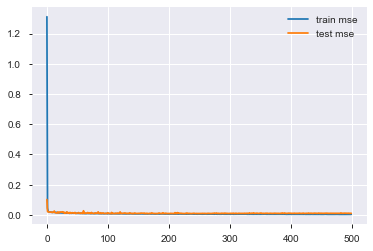

In [55]:
#結果の表示
import matplotlib.pyplot as plt #プロット用のライブラリを利用

print(model.evaluate(valid_X_nn, valid_y_nn))

train_acc = history.history['loss']
test_acc = history.history['val_loss']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train mse')
plt.plot(x, test_acc, label = 'test mse')
plt.legend() #グラフの線の説明を表示

In [57]:
pred_y=model.predict(valid_X_nn)
score=mean_absolute_error(np.exp(valid_y_nn),np.exp(model.predict(valid_X_nn)))
print(f'MAE:{score:4f}')#standard

MAE:25.888074


# Stacking

In [145]:
import numpy as np
import pandas as pd
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
# tensorflowの警告抑制
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# ---------------------------------
# データ等の準備
# ----------------------------------
import numpy as np
import pandas as pd


# ---------------------------------
# スタッキング
# ----------------------------------
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

# models.pyにModel1Xgb, Model1NN, Model2Linearを定義しているものとする
# 各クラスは、fitで学習し、predictで予測値の確率を出力する


# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test


# 1層目のモデル

model_1a =XGBRegressorCV(n_trials=30)
pred_train_1a, pred_test_1a = predict_cv(model_1a, X, y, test)

model_1b = LGBRegressorCV(n_trials=40)
pred_train_1b, pred_test_1b = predict_cv(model_1b, X, y, test)

model_1c = LGBRegressor1CV(n_trials=40)
# model=LGBRegressor1CV()
ylgm=min_max_normalization(y)
# model.fit(train_X,train_ylgm)
pred_train_1c, pred_test_1c = predict_cv(model_1c, X, ylgm, test)
pred_train_1c=min_max_renormalization(pred_train_1c,y)
pred_test_1c=min_max_renormalization(pred_test_1c,y)

model_1d = XGBRegressorCV(n_trials=30)
pred_train_1d, pred_test_1d = predict_cv(model_1d, X, y, test)

model_1e =  LGBRegressor2CV(n_trials=40)
pred_train_1e, pred_test_1e = predict_cv(model_1e, X, y, test)

# 1層目のモデルの評価
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1a))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1b))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1c))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1d))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1e))}')

# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a, 'pred_1b': pred_train_1b,'pred_1c': pred_train_1c,'pred_1d': pred_train_1d,'pred_1e': pred_train_1e})
test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a, 'pred_1b': pred_test_1b, 'pred_1c': pred_test_1c, 'pred_1d': pred_test_1d, 'pred_1e': pred_test_1e})



# train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a, 'pred_1b': pred_train_1b,'pred_1c': pred_train_1c})
# test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a, 'pred_1b': pred_test_1b, 'pred_1c': pred_test_1c})


# 2層目のモデル
# pred_train_2は、2層目のモデルの学習データのクロスバリデーションでの予測値
# pred_test_2は、2層目のモデルのテストデータの予測値
model_2 = XGBRegressorCV(n_trials=20)
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, y, test_x_2)
# model_2_a = XGBRegressorCV(n_trials=10)
# pred_train_2a, pred_test_2a = predict_cv(model_2_a, train_x_2, y, test_x_2)
# model_2_b = LGBRegressorCV(n_trials=20)
# pred_train_2b, pred_test_2b = predict_cv(model_2_b, train_x_2, y, test_x_2)

print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_2))}')

# print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_2a))}')
# print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_2b))}')

# train_x_3 = pd.DataFrame({'pred_1a': pred_train_2a, 'pred_1b': pred_train_2b})
# test_x_3 = pd.DataFrame({'pred_1a': pred_test_2a, 'pred_1b': pred_test_2b})



# model_3 = XGBRegressorCV(n_trials=10)
# pred_train_3, pred_test_3 = predict_cv(model_3, train_x_3, y, test_x_3)



[I 2019-11-18 00:07:31,605] Finished trial#0 resulted in value: 0.9231041336460892. Current best value is 0.9231041336460892 with parameters: {'booster': 'dart', 'alpha': 6.086576304138444e-05, 'max_depth': 10, 'eta': 1.6508429898676365e-07, 'gamma': 0.0020588488793062613, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.09212922206400888, 'skip_drop': 0.10828688152731958}.
[I 2019-11-18 00:07:34,101] Finished trial#1 resulted in value: 0.899390610613025. Current best value is 0.9231041336460892 with parameters: {'booster': 'dart', 'alpha': 6.086576304138444e-05, 'max_depth': 10, 'eta': 1.6508429898676365e-07, 'gamma': 0.0020588488793062613, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.09212922206400888, 'skip_drop': 0.10828688152731958}.
[I 2019-11-18 00:07:45,217] Finished trial#2 resulted in value: -1.0398152715439326. Current best value is 0.9231041336460892 with parameters: {'booster'


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 0.0014303239569109297, 'max_depth': 13, 'eta': 1.2773398143816896e-08, 'gamma': 0.0323139392952258, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.961771517277614e-06, 'skip_drop': 2.2982463821315274e-07}

[00:23:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 00:23:45,112] Finished trial#0 resulted in value: 0.89974247372589. Current best value is 0.89974247372589 with parameters: {'booster': 'gbtree', 'alpha': 0.0024568244786523953, 'max_depth': 2, 'eta': 0.0010098664246312858, 'gamma': 0.09174728202976384, 'grow_policy': 'depthwise'}.
[I 2019-11-18 00:24:24,898] Finished trial#1 resulted in value: 0.44828980044584055. Current best value is 0.89974247372589 with parameters: {'booster': 'gbtree', 'alpha': 0.0024568244786523953, 'max_depth': 2, 'eta': 0.0010098664246312858, 'gamma': 0.09174728202976384, 'grow_policy': 'depthwise'}.
[I 2019-11-18 00:24:46,735] Finished trial#2 resulted in value: 0.9561358728363277. Current best value is 0.9561358728363277 with parameters: {'booster': 'gbtree', 'alpha': 5.392063691999214e-07, 'max_depth': 20, 'eta': 5.377295899996159e-07, 'gamma': 0.05593469489373351, 'grow_policy': 'depthwise'}.
[I 2019-11-18 00:25:30,037] Finished trial#3 resulted in value: 0.9553407093005415. Current best valu


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 3.32539463845529e-06, 'max_depth': 10, 'eta': 5.666549640994005e-08, 'gamma': 0.018631559656417815, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.9450620063101815e-08, 'skip_drop': 1.1293245862628856e-08}

[00:36:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 00:37:20,304] Finished trial#0 resulted in value: 0.9536029565680607. Current best value is 0.9536029565680607 with parameters: {'booster': 'gbtree', 'alpha': 0.02024426845559168, 'max_depth': 20, 'eta': 0.22973585893657103, 'gamma': 2.3411205363474093e-05, 'grow_policy': 'depthwise'}.
[I 2019-11-18 00:37:29,683] Finished trial#1 resulted in value: 0.9572557624230056. Current best value is 0.9572557624230056 with parameters: {'booster': 'gbtree', 'alpha': 7.282752262534837e-07, 'max_depth': 9, 'eta': 0.006080352295941019, 'gamma': 0.010278283643731841, 'grow_policy': 'lossguide'}.
[I 2019-11-18 00:37:47,721] Finished trial#2 resulted in value: -8.080888374684886. Current best value is 0.9572557624230056 with parameters: {'booster': 'gbtree', 'alpha': 7.282752262534837e-07, 'max_depth': 9, 'eta': 0.006080352295941019, 'gamma': 0.010278283643731841, 'grow_policy': 'lossguide'}.
[I 2019-11-18 00:37:52,601] Finished trial#3 resulted in value: 0.8201010204957411. Current best 


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.0008288828206560095, 'max_depth': 13, 'eta': 7.599337030481685e-08, 'gamma': 0.03657457233468363, 'grow_policy': 'lossguide'}

[00:45:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 00:45:22,948] Finished trial#0 resulted in value: 0.8201723759303341. Current best value is 0.8201723759303341 with parameters: {'booster': 'dart', 'alpha': 7.468213149574587e-07, 'max_depth': 1, 'eta': 0.004906747512890723, 'gamma': 2.0017805698149672e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.0982715618483501e-08, 'skip_drop': 1.4137041463329005e-05}.
[I 2019-11-18 00:46:49,047] Finished trial#1 resulted in value: 0.9529941202198403. Current best value is 0.9529941202198403 with parameters: {'booster': 'dart', 'alpha': 1.1096016631412619e-05, 'max_depth': 18, 'eta': 5.148650518220747e-07, 'gamma': 0.00013453752655866316, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006313590926519565, 'skip_drop': 0.0026250277088215295}.
[I 2019-11-18 00:47:08,412] Finished trial#2 resulted in value: 0.9533424490381858. Current best value is 0.9533424490381858 with parameters: 


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 0.00013092980745494574, 'max_depth': 10, 'eta': 1.1929475732202426e-08, 'gamma': 1.4474787335198481e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.112901445965229e-07, 'skip_drop': 1.2133206093408e-06}

[01:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 01:05:53,714] Finished trial#0 resulted in value: 0.9543223833944559. Current best value is 0.9543223833944559 with parameters: {'iterations': 206, 'depth': 22, 'learning_rate': 0.07159748524809273, 'random_strength': 36, 'bagging_temperature': 0.3425446919357175, 'od_type': 'IncToDec', 'od_wait': 23}.
[I 2019-11-18 01:05:54,967] Finished trial#1 resulted in value: 0.9481568793015258. Current best value is 0.9543223833944559 with parameters: {'iterations': 206, 'depth': 22, 'learning_rate': 0.07159748524809273, 'random_strength': 36, 'bagging_temperature': 0.3425446919357175, 'od_type': 'IncToDec', 'od_wait': 23}.
[I 2019-11-18 01:05:57,303] Finished trial#2 resulted in value: 0.9551603748548636. Current best value is 0.9551603748548636 with parameters: {'iterations': 207, 'depth': 21, 'learning_rate': 0.08431119371480233, 'random_strength': 65, 'bagging_temperature': 58.04118126010834, 'od_type': 'IncToDec', 'od_wait': 30}.
[I 2019-11-18 01:05:59,717] Finished trial#3 re


Best score: 0.96
Best params: {'iterations': 396, 'depth': 11, 'learning_rate': 0.21704407033350406, 'random_strength': 35, 'bagging_temperature': 25.737448257433385, 'od_type': 'Iter', 'od_wait': 42}



[I 2019-11-18 01:07:07,662] Finished trial#0 resulted in value: 0.9115708784680601. Current best value is 0.9115708784680601 with parameters: {'iterations': 287, 'depth': 13, 'learning_rate': 0.023286193387971818, 'random_strength': 66, 'bagging_temperature': 65.53542997230883, 'od_type': 'Iter', 'od_wait': 29}.
[I 2019-11-18 01:07:10,472] Finished trial#1 resulted in value: 0.921469424741254. Current best value is 0.921469424741254 with parameters: {'iterations': 73, 'depth': 21, 'learning_rate': 0.025415487783220655, 'random_strength': 29, 'bagging_temperature': 0.3707802900620302, 'od_type': 'Iter', 'od_wait': 31}.
[I 2019-11-18 01:07:14,242] Finished trial#2 resulted in value: 0.9034222270746992. Current best value is 0.921469424741254 with parameters: {'iterations': 73, 'depth': 21, 'learning_rate': 0.025415487783220655, 'random_strength': 29, 'bagging_temperature': 0.3707802900620302, 'od_type': 'Iter', 'od_wait': 31}.
[I 2019-11-18 01:07:17,299] Finished trial#3 resulted in valu


Best score: 0.96
Best params: {'iterations': 280, 'depth': 11, 'learning_rate': 0.1412142759846413, 'random_strength': 22, 'bagging_temperature': 27.7024408555994, 'od_type': 'IncToDec', 'od_wait': 15}



[I 2019-11-18 01:08:28,312] Finished trial#0 resulted in value: 0.9557964212916972. Current best value is 0.9557964212916972 with parameters: {'iterations': 381, 'depth': 6, 'learning_rate': 0.09083193540034794, 'random_strength': 98, 'bagging_temperature': 0.011879184803105377, 'od_type': 'IncToDec', 'od_wait': 24}.
[I 2019-11-18 01:08:29,578] Finished trial#1 resulted in value: 0.9561483996090411. Current best value is 0.9561483996090411 with parameters: {'iterations': 63, 'depth': 11, 'learning_rate': 0.21952899035488313, 'random_strength': 7, 'bagging_temperature': 0.04499864801214259, 'od_type': 'Iter', 'od_wait': 28}.
[I 2019-11-18 01:08:31,500] Finished trial#2 resulted in value: 0.9561295103024637. Current best value is 0.9561483996090411 with parameters: {'iterations': 63, 'depth': 11, 'learning_rate': 0.21952899035488313, 'random_strength': 7, 'bagging_temperature': 0.04499864801214259, 'od_type': 'Iter', 'od_wait': 28}.
[I 2019-11-18 01:08:33,772] Finished trial#3 resulted i


Best score: 0.96
Best params: {'iterations': 50, 'depth': 21, 'learning_rate': 0.15662233929858735, 'random_strength': 33, 'bagging_temperature': 96.69378891178215, 'od_type': 'Iter', 'od_wait': 32}



[I 2019-11-18 01:09:45,901] Finished trial#0 resulted in value: 0.9446405921867902. Current best value is 0.9446405921867902 with parameters: {'iterations': 86, 'depth': 11, 'learning_rate': 0.6626632631663524, 'random_strength': 93, 'bagging_temperature': 1.7942376586341402, 'od_type': 'IncToDec', 'od_wait': 43}.
[I 2019-11-18 01:09:48,390] Finished trial#1 resulted in value: 0.9512877433099776. Current best value is 0.9512877433099776 with parameters: {'iterations': 103, 'depth': 11, 'learning_rate': 0.46396499620454934, 'random_strength': 52, 'bagging_temperature': 21.193016824534794, 'od_type': 'Iter', 'od_wait': 10}.
[I 2019-11-18 01:09:49,869] Finished trial#2 resulted in value: 0.9400135561494027. Current best value is 0.9512877433099776 with parameters: {'iterations': 103, 'depth': 11, 'learning_rate': 0.46396499620454934, 'random_strength': 52, 'bagging_temperature': 21.193016824534794, 'od_type': 'Iter', 'od_wait': 10}.
[I 2019-11-18 01:09:51,425] Finished trial#3 resulted in


Best score: 0.96
Best params: {'iterations': 249, 'depth': 15, 'learning_rate': 0.17456716655828444, 'random_strength': 9, 'bagging_temperature': 10.90153807428181, 'od_type': 'Iter', 'od_wait': 17}



[I 2019-11-18 01:11:00,014] Finished trial#0 resulted in value: 0.9516837951675541. Current best value is 0.9516837951675541 with parameters: {'iterations': 277, 'depth': 13, 'learning_rate': 0.05156985766852844, 'random_strength': 61, 'bagging_temperature': 71.18352365275888, 'od_type': 'IncToDec', 'od_wait': 50}.
[I 2019-11-18 01:11:02,107] Finished trial#1 resulted in value: 0.9548696641789114. Current best value is 0.9548696641789114 with parameters: {'iterations': 263, 'depth': 19, 'learning_rate': 0.07825816788913273, 'random_strength': 26, 'bagging_temperature': 0.010740738710730271, 'od_type': 'Iter', 'od_wait': 19}.
[I 2019-11-18 01:11:05,071] Finished trial#2 resulted in value: 0.9557013152979035. Current best value is 0.9557013152979035 with parameters: {'iterations': 252, 'depth': 11, 'learning_rate': 0.1346542703610219, 'random_strength': 75, 'bagging_temperature': 6.610988060946127, 'od_type': 'IncToDec', 'od_wait': 45}.
[I 2019-11-18 01:11:08,181] Finished trial#3 result


Best score: 0.96
Best params: {'iterations': 233, 'depth': 12, 'learning_rate': 0.14899531595438126, 'random_strength': 67, 'bagging_temperature': 0.18096320178995579, 'od_type': 'IncToDec', 'od_wait': 24}



[I 2019-11-18 01:12:20,155] Finished trial#0 resulted in value: 0.9521655055436726. Current best value is 0.9521655055436726 with parameters: {'iterations': 112, 'depth': 18, 'learning_rate': 0.3803861533466419, 'random_strength': 60, 'bagging_temperature': 1.5977335632022065, 'od_type': 'IncToDec', 'od_wait': 35}.
[I 2019-11-18 01:12:21,651] Finished trial#1 resulted in value: 0.9559810638412868. Current best value is 0.9559810638412868 with parameters: {'iterations': 286, 'depth': 16, 'learning_rate': 0.109907264518568, 'random_strength': 93, 'bagging_temperature': 0.022758539218565323, 'od_type': 'IncToDec', 'od_wait': 14}.
[I 2019-11-18 01:12:23,971] Finished trial#2 resulted in value: 0.9511998944545221. Current best value is 0.9559810638412868 with parameters: {'iterations': 286, 'depth': 16, 'learning_rate': 0.109907264518568, 'random_strength': 93, 'bagging_temperature': 0.022758539218565323, 'od_type': 'IncToDec', 'od_wait': 14}.
[I 2019-11-18 01:12:26,852] Finished trial#3 re


Best score: 0.96
Best params: {'iterations': 297, 'depth': 18, 'learning_rate': 0.13856533822293154, 'random_strength': 100, 'bagging_temperature': 0.04196588563832978, 'od_type': 'IncToDec', 'od_wait': 31}



[I 2019-11-18 01:13:37,039] Finished trial#0 resulted in value: 0.9565840189388639. Current best value is 0.9565840189388639 with parameters: {'iterations': 254, 'depth': 12, 'learning_rate': 0.1716141490302122, 'random_strength': 51, 'bagging_temperature': 0.25699795200617515, 'od_type': 'IncToDec', 'od_wait': 40}.
[I 2019-11-18 01:13:38,512] Finished trial#1 resulted in value: 0.95222141201689. Current best value is 0.9565840189388639 with parameters: {'iterations': 254, 'depth': 12, 'learning_rate': 0.1716141490302122, 'random_strength': 51, 'bagging_temperature': 0.25699795200617515, 'od_type': 'IncToDec', 'od_wait': 40}.
[I 2019-11-18 01:13:41,312] Finished trial#2 resulted in value: 0.9561179939296263. Current best value is 0.9565840189388639 with parameters: {'iterations': 254, 'depth': 12, 'learning_rate': 0.1716141490302122, 'random_strength': 51, 'bagging_temperature': 0.25699795200617515, 'od_type': 'IncToDec', 'od_wait': 40}.
[I 2019-11-18 01:13:44,498] Finished trial#3 res


Best score: 0.96
Best params: {'iterations': 279, 'depth': 12, 'learning_rate': 0.13343212894759812, 'random_strength': 40, 'bagging_temperature': 53.12866478968497, 'od_type': 'Iter', 'od_wait': 44}



[I 2019-11-18 01:14:56,483] Finished trial#0 resulted in value: 0.9531749221509476. Current best value is 0.9531749221509476 with parameters: {'iterations': 95, 'depth': 9, 'learning_rate': 0.05762938850548145, 'random_strength': 71, 'bagging_temperature': 14.036783079380124, 'od_type': 'IncToDec', 'od_wait': 45}.
[I 2019-11-18 01:14:58,650] Finished trial#1 resulted in value: 0.9551428004700654. Current best value is 0.9551428004700654 with parameters: {'iterations': 286, 'depth': 20, 'learning_rate': 0.2931045758126211, 'random_strength': 25, 'bagging_temperature': 3.955600276184128, 'od_type': 'Iter', 'od_wait': 28}.
[I 2019-11-18 01:14:59,908] Finished trial#2 resulted in value: 0.9498977403886052. Current best value is 0.9551428004700654 with parameters: {'iterations': 286, 'depth': 20, 'learning_rate': 0.2931045758126211, 'random_strength': 25, 'bagging_temperature': 3.955600276184128, 'od_type': 'Iter', 'od_wait': 28}.
[I 2019-11-18 01:15:01,175] Finished trial#3 resulted in val


Best score: 0.96
Best params: {'iterations': 204, 'depth': 19, 'learning_rate': 0.13533685822213493, 'random_strength': 53, 'bagging_temperature': 1.4798402004008846, 'od_type': 'Iter', 'od_wait': 10}



[I 2019-11-18 01:16:35,112] Finished trial#0 resulted in value: 0.9526179187115302. Current best value is 0.9526179187115302 with parameters: {'booster': 'gbtree', 'alpha': 0.02682663412460188, 'max_depth': 17, 'eta': 0.0010963102298908356, 'gamma': 0.0007686967488518943, 'grow_policy': 'lossguide'}.
[I 2019-11-18 01:18:10,405] Finished trial#1 resulted in value: 0.9517920642499975. Current best value is 0.9526179187115302 with parameters: {'booster': 'gbtree', 'alpha': 0.02682663412460188, 'max_depth': 17, 'eta': 0.0010963102298908356, 'gamma': 0.0007686967488518943, 'grow_policy': 'lossguide'}.
[I 2019-11-18 01:18:15,599] Finished trial#2 resulted in value: 0.9491467055114245. Current best value is 0.9526179187115302 with parameters: {'booster': 'gbtree', 'alpha': 0.02682663412460188, 'max_depth': 17, 'eta': 0.0010963102298908356, 'gamma': 0.0007686967488518943, 'grow_policy': 'lossguide'}.
[I 2019-11-18 01:19:04,952] Finished trial#3 resulted in value: 0.9458166420569338. Current be


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.002306645441057849, 'max_depth': 18, 'eta': 5.741780749181949e-07, 'gamma': 0.06724487265067969, 'grow_policy': 'lossguide'}

[01:27:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 01:28:49,111] Finished trial#0 resulted in value: 0.46241941196578845. Current best value is 0.46241941196578845 with parameters: {'booster': 'dart', 'alpha': 0.0013652114227291074, 'max_depth': 20, 'eta': 0.00023257061997255786, 'gamma': 5.487075765397128e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.009808103696177089, 'skip_drop': 4.168748859231646e-06}.
[I 2019-11-18 01:29:15,793] Finished trial#1 resulted in value: 0.9526976120203831. Current best value is 0.9526976120203831 with parameters: {'booster': 'gbtree', 'alpha': 0.001429857937490279, 'max_depth': 19, 'eta': 0.0006354316520048093, 'gamma': 7.759659572276464e-05, 'grow_policy': 'depthwise'}.
[I 2019-11-18 01:29:20,015] Finished trial#2 resulted in value: 0.9429779437086683. Current best value is 0.9526976120203831 with parameters: {'booster': 'gbtree', 'alpha': 0.001429857937490279, 'max_depth': 19, 'eta': 0.0006354316520048093, 'gamma': 7.759659572276464


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 0.9918564855299052, 'max_depth': 9, 'eta': 0.6463279346644428, 'gamma': 3.690151015254498e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0007752872068647249, 'skip_drop': 0.01071760384824538}

[01:44:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 01:45:08,726] Finished trial#0 resulted in value: 0.9539565776565372. Current best value is 0.9539565776565372 with parameters: {'booster': 'gbtree', 'alpha': 2.6032552330102733e-05, 'max_depth': 18, 'eta': 1.2795515798334098e-07, 'gamma': 6.540534685231774e-08, 'grow_policy': 'lossguide'}.
[I 2019-11-18 01:45:21,346] Finished trial#1 resulted in value: 0.9311916061195072. Current best value is 0.9539565776565372 with parameters: {'booster': 'gbtree', 'alpha': 2.6032552330102733e-05, 'max_depth': 18, 'eta': 1.2795515798334098e-07, 'gamma': 6.540534685231774e-08, 'grow_policy': 'lossguide'}.
[I 2019-11-18 01:45:43,855] Finished trial#2 resulted in value: 0.9497276873032948. Current best value is 0.9539565776565372 with parameters: {'booster': 'gbtree', 'alpha': 2.6032552330102733e-05, 'max_depth': 18, 'eta': 1.2795515798334098e-07, 'gamma': 6.540534685231774e-08, 'grow_policy': 'lossguide'}.
[I 2019-11-18 01:45:52,084] Finished trial#3 resulted in value: 0.9553756511843631


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.0551378896365902, 'max_depth': 10, 'eta': 4.737692151184728e-08, 'gamma': 1.0260097361559183e-08, 'grow_policy': 'lossguide'}

[01:52:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 01:52:27,423] Finished trial#0 resulted in value: -89.59025472463239. Current best value is -89.59025472463239 with parameters: {'booster': 'dart', 'alpha': 3.6620349372872935e-06, 'max_depth': 11, 'eta': 1.4692655844493763e-07, 'gamma': 0.9753109423814516, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.19413380136521374, 'skip_drop': 1.948502206668918e-07}.
[I 2019-11-18 01:53:12,099] Finished trial#1 resulted in value: 0.4834916133307578. Current best value is 0.4834916133307578 with parameters: {'booster': 'dart', 'alpha': 1.2296419210615355e-07, 'max_depth': 15, 'eta': 1.0741426715604304e-05, 'gamma': 0.07402801647106191, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.010196170058852603, 'skip_drop': 5.154364632252224e-06}.
[I 2019-11-18 01:53:23,814] Finished trial#2 resulted in value: 0.9562631509870112. Current best value is 0.9562631509870112 with parameters: {'boos


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.21105613839070558, 'max_depth': 14, 'eta': 0.0002814627154562749, 'gamma': 0.04539390689095847, 'grow_policy': 'depthwise'}

[02:02:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 02:02:25,192] Finished trial#0 resulted in value: 0.9542616623594616. Current best value is 0.9542616623594616 with parameters: {'iterations': 55, 'depth': 8, 'learning_rate': 0.067485485554835, 'random_strength': 70, 'bagging_temperature': 0.3220048113585638, 'od_type': 'Iter', 'od_wait': 25}.
[I 2019-11-18 02:02:26,788] Finished trial#1 resulted in value: 0.9415454242082353. Current best value is 0.9542616623594616 with parameters: {'iterations': 55, 'depth': 8, 'learning_rate': 0.067485485554835, 'random_strength': 70, 'bagging_temperature': 0.3220048113585638, 'od_type': 'Iter', 'od_wait': 25}.
[I 2019-11-18 02:02:29,692] Finished trial#2 resulted in value: 0.9427779497405663. Current best value is 0.9542616623594616 with parameters: {'iterations': 55, 'depth': 8, 'learning_rate': 0.067485485554835, 'random_strength': 70, 'bagging_temperature': 0.3220048113585638, 'od_type': 'Iter', 'od_wait': 25}.
[I 2019-11-18 02:02:32,562] Finished trial#3 resulted in value: 0.9496


Best score: 0.96
Best params: {'iterations': 309, 'depth': 13, 'learning_rate': 0.17736498401857698, 'random_strength': 3, 'bagging_temperature': 73.1109061759325, 'od_type': 'Iter', 'od_wait': 42}



[I 2019-11-18 02:03:45,660] Finished trial#0 resulted in value: 0.7911449313186725. Current best value is 0.7911449313186725 with parameters: {'iterations': 376, 'depth': 20, 'learning_rate': 0.015127938221865467, 'random_strength': 19, 'bagging_temperature': 0.028782209643954778, 'od_type': 'Iter', 'od_wait': 43}.
[I 2019-11-18 02:03:47,098] Finished trial#1 resulted in value: 0.956058412734544. Current best value is 0.956058412734544 with parameters: {'iterations': 357, 'depth': 19, 'learning_rate': 0.11941659311996917, 'random_strength': 4, 'bagging_temperature': 54.12587587839169, 'od_type': 'Iter', 'od_wait': 16}.
[I 2019-11-18 02:03:48,542] Finished trial#2 resulted in value: 0.9554175899432422. Current best value is 0.956058412734544 with parameters: {'iterations': 357, 'depth': 19, 'learning_rate': 0.11941659311996917, 'random_strength': 4, 'bagging_temperature': 54.12587587839169, 'od_type': 'Iter', 'od_wait': 16}.
[I 2019-11-18 02:03:50,057] Finished trial#3 resulted in value


Best score: 0.96
Best params: {'iterations': 108, 'depth': 24, 'learning_rate': 0.12573775629319217, 'random_strength': 46, 'bagging_temperature': 0.14356152054210755, 'od_type': 'Iter', 'od_wait': 26}



[I 2019-11-18 02:05:02,707] Finished trial#0 resulted in value: 0.9434480144052774. Current best value is 0.9434480144052774 with parameters: {'iterations': 339, 'depth': 25, 'learning_rate': 0.03578722424253087, 'random_strength': 53, 'bagging_temperature': 3.431942795370851, 'od_type': 'Iter', 'od_wait': 42}.
[I 2019-11-18 02:05:04,217] Finished trial#1 resulted in value: 0.9557861138825586. Current best value is 0.9557861138825586 with parameters: {'iterations': 323, 'depth': 10, 'learning_rate': 0.0886637129797413, 'random_strength': 50, 'bagging_temperature': 35.824959326013214, 'od_type': 'Iter', 'od_wait': 31}.
[I 2019-11-18 02:05:05,683] Finished trial#2 resulted in value: 0.9533854989969456. Current best value is 0.9557861138825586 with parameters: {'iterations': 323, 'depth': 10, 'learning_rate': 0.0886637129797413, 'random_strength': 50, 'bagging_temperature': 35.824959326013214, 'od_type': 'Iter', 'od_wait': 31}.
[I 2019-11-18 02:05:08,045] Finished trial#3 resulted in valu


Best score: 0.96
Best params: {'iterations': 296, 'depth': 10, 'learning_rate': 0.15361106242434294, 'random_strength': 99, 'bagging_temperature': 0.35057275172136726, 'od_type': 'Iter', 'od_wait': 31}



[I 2019-11-18 02:06:21,285] Finished trial#0 resulted in value: 0.9536538239514893. Current best value is 0.9536538239514893 with parameters: {'iterations': 319, 'depth': 11, 'learning_rate': 0.3282453607079081, 'random_strength': 39, 'bagging_temperature': 0.8084710241968928, 'od_type': 'Iter', 'od_wait': 21}.
[I 2019-11-18 02:06:23,600] Finished trial#1 resulted in value: 0.9481122026300935. Current best value is 0.9536538239514893 with parameters: {'iterations': 319, 'depth': 11, 'learning_rate': 0.3282453607079081, 'random_strength': 39, 'bagging_temperature': 0.8084710241968928, 'od_type': 'Iter', 'od_wait': 21}.
[I 2019-11-18 02:06:25,831] Finished trial#2 resulted in value: 0.9491572110299906. Current best value is 0.9536538239514893 with parameters: {'iterations': 319, 'depth': 11, 'learning_rate': 0.3282453607079081, 'random_strength': 39, 'bagging_temperature': 0.8084710241968928, 'od_type': 'Iter', 'od_wait': 21}.
[I 2019-11-18 02:06:28,301] Finished trial#3 resulted in valu


Best score: 0.96
Best params: {'iterations': 310, 'depth': 23, 'learning_rate': 0.14808412898154835, 'random_strength': 45, 'bagging_temperature': 1.4087450985681664, 'od_type': 'IncToDec', 'od_wait': 18}

logloss: 22.8938488631003
logloss: 23.51282829294355
logloss: 23.339861396752234
logloss: 22.999829644732852
logloss: 23.33241722419278


[I 2019-11-18 02:07:56,464] Finished trial#0 resulted in value: 0.9571015979279499. Current best value is 0.9571015979279499 with parameters: {'booster': 'dart', 'alpha': 1.7327155736206814e-05, 'max_depth': 8, 'eta': 1.1326205819416483e-08, 'gamma': 4.9831168267678245e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.7823392072417081e-06, 'skip_drop': 1.2228163939399025e-05}.
[I 2019-11-18 02:08:02,694] Finished trial#1 resulted in value: 0.4852002466104765. Current best value is 0.9571015979279499 with parameters: {'booster': 'dart', 'alpha': 1.7327155736206814e-05, 'max_depth': 8, 'eta': 1.1326205819416483e-08, 'gamma': 4.9831168267678245e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.7823392072417081e-06, 'skip_drop': 1.2228163939399025e-05}.
[I 2019-11-18 02:08:09,685] Finished trial#2 resulted in value: 0.9573398677923045. Current best value is 0.9573398677923045 with paramete


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 2.436079436816543e-07, 'max_depth': 3, 'eta': 0.16540730810876714, 'gamma': 4.0766569189733186e-07, 'grow_policy': 'lossguide'}

[02:10:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 02:10:36,576] Finished trial#0 resulted in value: 0.9577636588636151. Current best value is 0.9577636588636151 with parameters: {'booster': 'dart', 'alpha': 1.856824245549206e-05, 'max_depth': 7, 'eta': 0.00024231535167626387, 'gamma': 0.21962282176850026, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.046863458320722e-07, 'skip_drop': 0.12954859594628623}.
[I 2019-11-18 02:10:38,779] Finished trial#1 resulted in value: 0.9583854722966485. Current best value is 0.9583854722966485 with parameters: {'booster': 'gbtree', 'alpha': 1.678271637439005e-08, 'max_depth': 2, 'eta': 0.5363769199598138, 'gamma': 0.009740633651887388, 'grow_policy': 'lossguide'}.
[I 2019-11-18 02:10:48,362] Finished trial#2 resulted in value: -553.1402353507607. Current best value is 0.9583854722966485 with parameters: {'booster': 'gbtree', 'alpha': 1.678271637439005e-08, 'max_depth': 2, 'eta': 0.5363769199598138, 'gamma': 0.009740633651887388, 'grow_


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.0012969205822539209, 'max_depth': 5, 'eta': 1.9105249415616308e-08, 'gamma': 2.1898588901474002e-05, 'grow_policy': 'depthwise'}

[02:14:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 02:15:12,189] Finished trial#0 resulted in value: 0.9573579108729356. Current best value is 0.9573579108729356 with parameters: {'booster': 'dart', 'alpha': 1.6258996257214328e-08, 'max_depth': 19, 'eta': 2.870049720270609e-07, 'gamma': 9.379783105876038e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0010543572390890336, 'skip_drop': 0.00554756313238667}.
[I 2019-11-18 02:15:13,754] Finished trial#1 resulted in value: 0.9571478845344984. Current best value is 0.9573579108729356 with parameters: {'booster': 'dart', 'alpha': 1.6258996257214328e-08, 'max_depth': 19, 'eta': 2.870049720270609e-07, 'gamma': 9.379783105876038e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0010543572390890336, 'skip_drop': 0.00554756313238667}.
[I 2019-11-18 02:15:18,289] Finished trial#2 resulted in value: 0.9591961493428129. Current best value is 0.9591961493428129 with parameters: {'


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 6.996226813768663e-05, 'max_depth': 4, 'eta': 0.01127253284451218, 'gamma': 0.006391483843431657, 'grow_policy': 'lossguide'}

[02:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-18 02:18:21,613] Finished trial#0 resulted in value: 0.9586701935933031. Current best value is 0.9586701935933031 with parameters: {'booster': 'dart', 'alpha': 0.3884935436619084, 'max_depth': 10, 'eta': 0.0002915905022358435, 'gamma': 4.873025416031647e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.5959782585984764e-08, 'skip_drop': 4.07110864851157e-05}.
[I 2019-11-18 02:18:33,072] Finished trial#1 resulted in value: 0.9573301047465665. Current best value is 0.9586701935933031 with parameters: {'booster': 'dart', 'alpha': 0.3884935436619084, 'max_depth': 10, 'eta': 0.0002915905022358435, 'gamma': 4.873025416031647e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.5959782585984764e-08, 'skip_drop': 4.07110864851157e-05}.
[I 2019-11-18 02:19:12,011] Finished trial#2 resulted in value: 0.9572099942068226. Current best value is 0.9586701935933031 with parameters: {'booster': 


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 0.021358258939391386, 'max_depth': 3, 'eta': 0.0006127746632220046, 'gamma': 0.0001803895393028509, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.4444940635420593e-05, 'skip_drop': 9.443337132248579e-08}

[02:22:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
logloss: 22.82975441225479


In [ ]:
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_2))}')

In [147]:
pred=np.exp(pred_test_2)

In [263]:
# xgbr = XGBRegressorCV(n_trials=40)

xgbr.fit(X, y)

pred=np.exp(xgbr.predict(test))

[I 2019-11-18 13:49:07,705] Finished trial#0 resulted in value: 0.9570822973844908. Current best value is 0.9570822973844908 with parameters: {'booster': 'dart', 'alpha': 1.8116001653174165e-06, 'max_depth': 8, 'eta': 0.07858215917034943, 'gamma': 0.0015142628399525304, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.005727057073313605, 'skip_drop': 0.03465274810290912}.
[I 2019-11-18 13:51:55,932] Finished trial#1 resulted in value: 0.9568129939467559. Current best value is 0.9570822973844908 with parameters: {'booster': 'dart', 'alpha': 1.8116001653174165e-06, 'max_depth': 8, 'eta': 0.07858215917034943, 'gamma': 0.0015142628399525304, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.005727057073313605, 'skip_drop': 0.03465274810290912}.
[I 2019-11-18 13:53:29,196] Finished trial#2 resulted in value: 0.773097295592646. Current best value is 0.9570822973844908 with parameters: {'booster': '


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 4.473659767090225e-08, 'max_depth': 11, 'eta': 0.16314345660264348, 'gamma': 0.010833429293200603, 'grow_policy': 'depthwise'}

[14:25:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [265]:
sub = pd.DataFrame(pd.read_csv("test_data.csv")['id'])
sub["y"] = list(pred)
sub.to_csv("submission.csv", index = False)